In [2]:
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
  init_notebook_mode(connected=False)

In [3]:
import plotly.express as px
from plotly.offline import iplot
import plotly.graph_objs as go
import plotly as py
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate
from sklearn.metrics import accuracy_score,plot_confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,VotingClassifier
from lightgbm import LGBMClassifier



In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
data = pd.read_csv('/content/drive/MyDrive/Anemia.csv')

In [13]:
data.head()

,NO,LAB_TEST,RESULT,REFERENCE_INTERVAL,GENDER,IDENTIFICATION
0,1,Hemoglobin,14.9,13.5 - 17.5,Male,Not Anemia
1,1,MCH,22.7,27.0 - 31.0,Male,Not Anemia
2,1,MCHC,29.1,32.0 - 36.0,Male,Not Anemia
3,1,MCV,83.7,82.0 - 92.0,Male,Not Anemia
4,2,Hemoglobin,15.9,12.0 - 16.0,Female,Not Anemia


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5684 entries, 0 to 5683
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   NO                  5684 non-null   int64  
 1   LAB_TEST            5684 non-null   object 
 2   RESULT              5684 non-null   float64
 3   REFERENCE_INTERVAL  5684 non-null   object 
 4   GENDER              5684 non-null   object 
 5   IDENTIFICATION      5684 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 266.6+ KB


In [9]:
data.describe(include='O').T

,count,unique,top,freq
LAB_TEST,5684,4,MCH,1421
REFERENCE_INTERVAL,5684,12,32.0 - 36.0,1409
IDENTIFICATION,5684,2,Not Anemia,3060


In [10]:
data.IDENTIFICATION.value_counts()

Not Anemia    3060
Anemia        2624
Name: IDENTIFICATION, dtype: int64

# Pre-Processing


In [15]:
data.loc[:,'IDENTIFICATION'].replace(to_replace=['Not Anemia', 'Anemia'],value = [0, 1], inplace = True)
data.loc[:,'GENDER'].replace(to_replace=['Male', 'Female'],value = [0, 1], inplace = True)

In [ ]:
data.head()

,NO,LAB_TEST,RESULT,REFERENCE_INTERVAL,GENDER,IDENTIFICATION
0,1,Hemoglobin,14.9,13.5 - 17.5,0,0
1,1,MCH,22.7,27.0 - 31.0,0,0
2,1,MCHC,29.1,32.0 - 36.0,0,0
3,1,MCV,83.7,82.0 - 92.0,0,0
4,2,Hemoglobin,15.9,12.0 - 16.0,1,0


In [35]:
prep_data = data.pivot_table('RESULT', ['NO','GENDER', 'IDENTIFICATION'],'LAB_TEST').reset_index(drop=False)

In [36]:
prep_data.head()

LAB_TEST,NO,GENDER,IDENTIFICATION,Hemoglobin,MCH,MCHC,MCV
0,1,0,0,14.9,22.7,29.1,83.7
1,2,1,0,15.9,25.4,28.3,72.0
2,3,1,1,9.0,21.5,29.6,71.2
3,4,1,0,14.9,16.0,31.4,87.5
4,5,0,0,14.7,22.0,28.2,99.5


In [30]:
def pie_chart_maker(df, title):
    enable_plotly_in_cell()
    colors = ['rgb(252,232,0)','rgb(35,31,32)']
    pie1 = go.Figure()
    pie1.add_trace(
            go.Pie(
                labels=df.value_counts().index.to_list(),
                values=df.value_counts()

            )
        )
    pie1.update_traces(
        title = title,
        titleposition ='bottom center',
        titlefont = dict(
            family='arial',
            size=25,
            color='Black'

        ),
        pull =[0.2,0],
        hoverinfo='label+percent',
        textinfo='label+percent',
        marker=dict(
        colors=colors
       )
    )
    pie1.update_layout(
        paper_bgcolor = 'rgb(243,243,243)',
        plot_bgcolor = 'rgb(243,243,243)'
    )
    pie1.show()

In [31]:
pie_chart_maker(prep_data['GENDER'],'GENDER')

Output hidden; open in https://colab.research.google.com to view.

In [32]:
pie_chart_maker(prep_data.loc[(prep_data.GENDER== 0),'IDENTIFICATION'],'IDENTIFICATION OF MALE')

Output hidden; open in https://colab.research.google.com to view.

In [33]:
pie_chart_maker(prep_data.loc[(prep_data.GENDER== 1),'IDENTIFICATION'],'IDENTIFICATION OF FEMALE')

Output hidden; open in https://colab.research.google.com to view.

# MODELING

In [37]:
X = prep_data.drop(columns=['IDENTIFICATION', 'NO'])
y = prep_data['IDENTIFICATION']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
print('X_train size: {}, X_test size: {}'.format(X_train.shape, X_test.shape))
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train size: (1136, 5), X_test size: (285, 5)


In [38]:
pca=PCA(n_components=2)
trans=pca.fit_transform(X_train)
enable_plotly_in_cell()
px.scatter(trans,x=trans[:,0],y=trans[:,1],color=y_train)



Output hidden; open in https://colab.research.google.com to view.

In [39]:
tsne=TSNE(n_components=2,learning_rate='auto')
trans=tsne.fit_transform(X_train)
enable_plotly_in_cell()
px.scatter(trans,x=trans[:,0],y=trans[:,1],color=y_train)

Output hidden; open in https://colab.research.google.com to view.

In [40]:
def find_best_model(X, y):
    models = {
        'logistic_regression': {
            'model': LogisticRegression(solver='lbfgs', multi_class='auto'),
            'parameters': {
                'C': [1,5,10]
               }
        },
        
        'decision_tree': {
            'model': DecisionTreeClassifier(splitter='best'),
            'parameters': {
                'criterion': ['gini', 'entropy'],
                'max_depth': [5,10]
            }
        },
        
        'random_forest': {
            'model': RandomForestClassifier(criterion='gini'),
            'parameters': {
                'n_estimators': [10,15,20,50,100,200]
            }
        },
        
        'svm': {
            'model': SVC(gamma='auto'),
            'parameters': {
                'C': [1,10,20],
                'kernel': ['rbf','linear']
            }
        },
        'GradientBoostingClassifier':{
            'model': GradientBoostingClassifier(random_state=1),
            'parameters': {
                'learning_rate': [0.01,0.1,0.5,1,10,100],
                'n_estimators': [50,100,150,200]
            }
        },
        'LightGBC':{
            'model': LGBMClassifier(random_state=1),
            'parameters': {
                'learning_rate': [0.01,0.1,0.5,1,10,100],
                'max_depth':[5,10,15,20]
            }            
        },
        'XGBoost':{
            'model': xgb.XGBClassifier(),
            'parameters': {
                'learning_rate': [0.01,0.1,0.5,1,10,100],
                'max_depth':[5,10,15,20],
                'n_estimators':[50,100,150]
            }        
        },
        'AdaBoost':{
            'model': AdaBoostClassifier(),
            'parameters': {
                'learning_rate': [0.01,0.1,0.5,1,10,100],
                'n_estimators':[50,100,150],
                'algorithm':['SAMME', 'SAMME.R']
            }    
        }

    }
    
    scores = [] 
    cv_shuffle = ShuffleSplit(n_splits=5, test_size=0.20, random_state=0)
        
    for model_name, model_params in models.items():
        gs = GridSearchCV(model_params['model'], model_params['parameters'], cv = cv_shuffle, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': model_name,
            'best_parameters': gs.best_params_,
            'score': gs.best_score_
        })
        
    return pd.DataFrame(scores, columns=['model','best_parameters','score'])

find_best_model(X_train, y_train)

,model,best_parameters,score
0,logistic_regression,{'C': 10},0.993860
1,decision_tree,"{'criterion': 'gini', 'max_depth': 5}",1.000000
2,random_forest,{'n_estimators': 20},1.000000
3,svm,"{'C': 20, 'kernel': 'linear'}",0.995614
4,GradientBoostingClassifier,"{'learning_rate': 0.01, 'n_estimators': 50}",1.000000
5,LightGBC,"{'learning_rate': 0.01, 'max_depth': 5}",1.000000
6,XGBoost,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",1.000000
7,AdaBoost,"{'algorithm': 'SAMME', 'learning_rate': 0.1, '...",1.000000


In [41]:
vot=[
    ('XGBOOST',xgb.XGBClassifier(learning_rate=0.01, max_depth=5, n_estimators=50)),
    ('LightGBC',LGBMClassifier(random_state=1, learning_rate=0.01, max_depth=5)),
    ('random forest', RandomForestClassifier(criterion='gini',n_estimators=10)),
    ('adaboost',AdaBoostClassifier(learning_rate=0.1,algorithm='SAMME',n_estimators=50))
]

In [42]:
voter=VotingClassifier(estimators=vot)
voter.fit(X_train,y_train)
print("Training accuracy : ",accuracy_score(y_train, voter.predict(X_train)))
print("Testing accuracy : ",accuracy_score(y_test, voter.predict(X_test)))


Training accuracy :  1.0
Testing accuracy :  1.0


In [43]:
voter_cv=cross_validate(voter,X,y,cv=5,return_train_score=True)
print("Training accuracy : ", voter_cv['train_score'].mean())
print("Testing accuracy : ", voter_cv['test_score'].mean())

Training accuracy :  1.0
Testing accuracy :  1.0


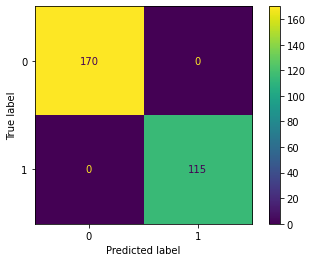

In [44]:
plot_confusion_matrix(voter, X_test, y_test) 

In [45]:
wprint(classification_report(y_test, voter.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       170
           1       1.00      1.00      1.00       115

    accuracy                           1.00       285
   macro avg       1.00      1.00      1.00       285
weighted avg       1.00      1.00      1.00       285



In [46]:
food_data = pd.read_csv('/content/drive/MyDrive/food.csv')

In [47]:
food_data.head()

,Category,Description,Nutrient Data Bank Number,Data.Alpha Carotene,Data.Ash,Data.Beta Carotene,Data.Beta Cryptoxanthin,Data.Carbohydrate,Data.Cholesterol,Data.Choline,Data.Fiber,Data.Kilocalories,Data.Lutein and Zeaxanthin,Data.Lycopene,Data.Manganese,Data.Niacin,Data.Pantothenic Acid,Data.Protein,Data.Refuse Percentage,Data.Retinol,Data.Riboflavin,Data.Selenium,Data.Sugar Total,Data.Thiamin,Data.Water,Data.Fat.Monosaturated Fat,Data.Fat.Polysaturated Fat,Data.Fat.Saturated Fat,Data.Fat.Total Lipid,Data.Household Weights.1st Household Weight,Data.Household Weights.1st Household Weight Description,Data.Household Weights.2nd Household Weight,Data.Household Weights.2nd Household Weight Description,Data.Major Minerals.Calcium,Data.Major Minerals.Copper,Data.Major Minerals.Iron,Data.Major Minerals.Magnesium,Data.Major Minerals.Phosphorus,Data.Major Minerals.Potassium,Data.Major Minerals.Sodium,Data.Major Minerals.Zinc,Data.Vitamins.Vitamin A - IU,Data.Vitamins.Vitamin A - RAE,Data.Vitamins.Vitamin B12,Data.Vitamins.Vitamin B6,Data.Vitamins.Vitamin C,Data.Vitamins.Vitamin E,Data.Vitamins.Vitamin K
0,BUTTER,"BUTTER,WITH SALT",1001,0,2.11,158,0,0.06,215,19,0.0,717,0,0,0.000,0.042,0.110,0.85,0,671,0.034,1.0,0.06,0.005,15.87,21.021,3.043,51.368,81.11,227.00,1 cup,14,1 tbsp,24,0.000,0.02,2,24,24,576,0.09,2499,684,0.17,0.003,0.0,2.32,7.0
1,BUTTER,"BUTTER,WHIPPED,WITH SALT",1002,0,2.11,158,0,0.06,219,19,0.0,717,0,0,0.004,0.042,0.110,0.85,0,671,0.034,1.0,0.06,0.005,15.87,23.426,3.012,50.489,81.11,151.00,1 cup,9,1 tbsp,24,0.016,0.16,2,23,26,827,0.05,2499,684,0.13,0.003,0.0,2.32,7.0
2,BUTTER OIL,"BUTTER OIL,ANHYDROUS",1003,0,0.00,193,0,0.00,256,22,0.0,876,0,0,0.000,0.003,0.010,0.28,0,824,0.005,0.0,0.00,0.001,0.24,28.732,3.694,61.924,99.48,205.00,1 cup,13,1 tbsp,4,0.001,0.00,0,3,5,2,0.01,3069,840,0.01,0.001,0.0,2.80,8.6
3,CHEESE,"CHEESE,BLUE",1004,0,5.11,74,0,2.34,75,15,0.0,353,0,0,0.009,1.016,1.729,21.40,0,192,0.382,14.5,0.50,0.029,42.41,7.778,0.800,18.669,28.74,28.35,1 oz,17,1 cubic inch,528,0.040,0.31,23,387,256,1395,2.66,763,198,1.22,0.166,0.0,0.25,2.4
4,CHEESE,"CHEESE,BRICK",1005,0,3.18,76,0,2.79,94,15,0.0,371,0,0,0.012,0.118,0.288,23.24,0,286,0.351,14.5,0.51,0.014,41.11,8.598,0.784,18.764,29.68,132.00,"1 cup, diced",113,"1 cup, shredded",674,0.024,0.43,24,451,136,560,2.60,1080,292,1.26,0.065,0.0,0.26,2.5


In [48]:
food_data.columns

Index(['Category', 'Description', 'Nutrient Data Bank Number',
       'Data.Alpha Carotene', 'Data.Ash', 'Data.Beta Carotene',
       'Data.Beta Cryptoxanthin', 'Data.Carbohydrate', 'Data.Cholesterol',
       'Data.Choline', 'Data.Fiber', 'Data.Kilocalories',
       'Data.Lutein and Zeaxanthin', 'Data.Lycopene', 'Data.Manganese',
       'Data.Niacin', 'Data.Pantothenic Acid', 'Data.Protein',
       'Data.Refuse Percentage', 'Data.Retinol', 'Data.Riboflavin',
       'Data.Selenium', 'Data.Sugar Total', 'Data.Thiamin', 'Data.Water',
       'Data.Fat.Monosaturated Fat', 'Data.Fat.Polysaturated Fat',
       'Data.Fat.Saturated Fat', 'Data.Fat.Total Lipid',
       'Data.Household Weights.1st Household Weight',
       'Data.Household Weights.1st Household Weight Description',
       'Data.Household Weights.2nd Household Weight',
       'Data.Household Weights.2nd Household Weight Description',
       'Data.Major Minerals.Calcium', 'Data.Major Minerals.Copper',
       'Data.Major Minerals.Iro

In [49]:
food_anemia_data = food_data.loc[:,['Category','Description','Data.Major Minerals.Iron']]

In [50]:
food_anemia_data = food_anemia_data.rename(columns={'Data.Major Minerals.Iron' : 'Iron'})

In [52]:
anemia_rec=food_anemia_data.loc[food_anemia_data.groupby(by='Category').Iron.idxmax()].sort_values('Iron', ascending=False)
anemia_rec.head(25)

,Category,Description,Iron
228,SPICES,"SPICES,THYME,DRIED",123.60
216,PARSLEY,"PARSLEY,DRIED",97.86
245,SPEARMINT,"SPEARMINT,DRIED",87.47
210,MARJORAM,"MARJORAM,DRIED",82.71
7022,WHALE,"WHALE,BELUGA,MEAT,DRIED (ALASKA NATIVE)",72.35
2119,CEREALS RTE,"CEREALS RTE,RALSTON ENR BRAN FLAKES",67.67
380,BABYFOOD,"BABYFOOD,CRL,OATMEAL,W/HONEY,DRY",67.23
201,No Category,CUMIN SEED,66.36
1849,CEREALS,"CEREALS,MALT-O-MEAL,PLN,DRY",55.70
7057,Seal,"Seal, bearded (Oogruk), meat, dried (Alaska Na...",49.60
